<a href="https://colab.research.google.com/github/ColeJMitchell/machine-learning-stock-prediction/blob/main/stock_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dependencies For The Project**

In [90]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# Dependencies for the LSTM model
from sklearn.preprocessing import MinMaxScaler
!pip install --upgrade tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.utils import pad_sequences
!pip install gputil
import GPUtil as GPU
from IPython.display import clear_output
clear_output()

In [91]:
# Ensure a GPU is available before running the model
GPUs = GPU.getGPUs()
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if len(tf.config.experimental.list_physical_devices('GPU')) > 0:
  gpu = GPUs[0]

Num GPUs Available:  0


# **Testing Using Apple Ticker And Performing Exploratory Data Analysis**

[*********************100%***********************]  1 of 1 completed


Price            Close        High         Low        Open     Volume
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL
Date                                                                 
2023-01-03  123.632538  129.395526  122.742880  128.782657  112117500
2023-01-04  124.907707  127.181276  123.642420  125.431615   89113600
2023-01-05  123.583099  126.301493  123.326093  125.668849   80962700
2023-01-06  128.130234  128.792531  123.454601  124.561732   87754700
2023-01-09  128.654129  131.876670  128.397123  128.970458   70790800
---------------------------------------------------------------------
Price        Close        High         Low        Open        Volume
Ticker        AAPL        AAPL        AAPL        AAPL          AAPL
count   250.000000  250.000000  250.000000  250.000000  2.500000e+02
mean    171.093880  172.391077  169.540436  170.804350  5.921703e+07
std      17.399657   17.331271   17.598673   17.596274  1.777392e+07
min     123.583099  126.3

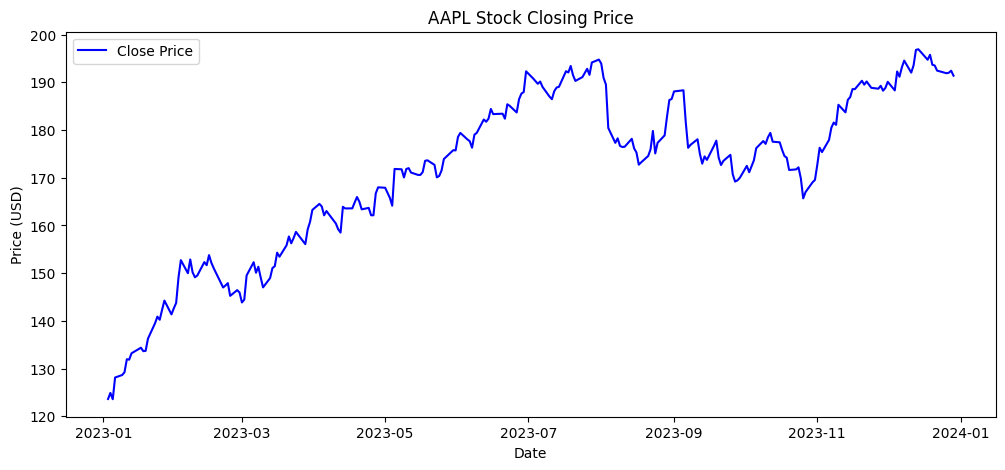

In [92]:
# API call to download Apple stock data
ticker = "AAPL"
df = yf.download(ticker, start="2023-01-01", end="2024-01-01")
print(df.head())
print("---------------------------------------------------------------------")

print(df.describe())
print("---------------------------------------------------------------------")

# Plot of trend in closing price
plt.figure(figsize=(12, 5))
plt.plot(df["Close"], label="Close Price", color='blue')
plt.title(f"{ticker} Stock Closing Price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()
print("\n")

# **Parsing Stock Ticker Text File From Data Directory**

In [97]:
stock_tickers = []
dates = []
with open("updated_tickers.txt", "r") as f:
  for line in f:
    parts = line.split("/", 1)

    # Get rid of some wrong tickers and keep a list of the post times for the sentiment analysis model
    if parts[0].strip() != "None" and parts[0].strip != "NONE" and parts[0].strip().upper() not in stock_tickers and parts[0].strip().isalpha():
      stock_tickers.append(parts[0].strip().upper())
      dt = datetime.datetime.utcfromtimestamp(float(parts[1].strip()))
      dates.append(dt.strftime('%Y-%m-%d'))

print(f"First 10 Stock Tickers: {stock_tickers[:10]}")
print(f"First 10 Posting Dates: {dates[:10]}")

First 10 Stock Tickers: ['AAPL', 'NVDA', 'MSTR', 'MP', 'PG', 'GLD', 'TSLA', 'AMC', 'META', 'HIMS']
First 10 Posting Dates: ['2025-04-16', '2025-04-16', '2025-04-16', '2025-04-16', '2025-04-16', '2025-04-16', '2025-04-16', '2025-04-16', '2025-04-16', '2025-04-15']


# **Dataframe From Stock Tickers**


In [94]:
all_data = []
for ticker in stock_tickers:
    df = yf.download(ticker, start='2020-01-01', end='2025-01-01')
    df["Ticker"] = ticker
    all_data.append(df)

# Combine ticker data into one DataFrame
final_df = pd.concat(all_data)
clear_output()
print(final_df.head())

Price           Close       High        Low       Open       Volume Ticker  \
Ticker           AAPL       AAPL       AAPL       AAPL         AAPL          
Date                                                                         
2020-01-02  72.716072  72.776598  71.466812  71.721019  135480400.0   AAPL   
2020-01-03  72.009117  72.771745  71.783962  71.941328  146322800.0   AAPL   
2020-01-06  72.582909  72.621646  70.876075  71.127866  118387200.0   AAPL   
2020-01-07  72.241539  72.849216  72.021223  72.592586  108872000.0   AAPL   
2020-01-08  73.403641  73.706271  71.943751  71.943751  132079200.0   AAPL   

Price      Close High  Low Open  ... High  Low Open Volume Adj Close Close  \
Ticker      NVDA NVDA NVDA NVDA  ... NONE NONE NONE   NONE       FED   FED   
Date                             ...                                         
2020-01-02   NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN    NaN       NaN   NaN   
2020-01-03   NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN    NaN     

# **Normalization And Preprocessing**

In [98]:
unique_tickers = final_df["Ticker"].unique()
total_data = []

# Add the closing prices for each of the tickers for the last five years
for ticker in unique_tickers:
  ticker_data = final_df[final_df["Ticker"] == ticker]["Close"].values
  if ticker_data.size > 0:
    total_data.append(ticker_data)

# First normalize the data then append it to a numpy array
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_data = []
for entry in total_data:
  entry = entry[~np.isnan(entry)]
  if entry.size == 0:
        continue
  # Min max scalar expects a 2d array
  reshaped_entry = entry.reshape(-1, 1)
  temp = scaler.fit_transform(reshaped_entry)
  normalized_data.append(temp.squeeze())

normalized_data = np.array(normalized_data, dtype=object)
normalized_data = pad_sequences(normalized_data, padding='post', dtype='float32')
print(f"Normalized Data Shape: {normalized_data.shape}")
print(f"First 10 Normalized Closing Prices: \n {normalized_data[:10]}")

Normalized Data Shape: (67, 1258)
First 10 Normalized Closing Prices: 
 [[0.08941492 0.0859543  0.08876307 ... 0.9832283  0.96665215 0.95794845]
 [0.00750315 0.00683916 0.00701035 ... 0.9176276  0.9209615  0.89873576]
 [0.01121586 0.01105659 0.01120294 ... 0.69042856 0.6322292  0.60351694]
 ...
 [0.11504281 0.11280942 0.10961889 ... 0.00245574 0.00240759 0.00242364]
 [0.22150545 0.21947132 0.22667342 ... 0.94047064 0.9247052  0.9141645 ]
 [0.21818766 0.21818766 0.21818766 ... 0.7535347  0.7088689  0.67705655]]


# **Training/Validation/Test Split**

In [132]:
print(f"Total Dataset Shape: {normalized_data.shape}")
print("---------------------------------------------------------------------")
# Because stock data for five years the training data is split 85%/15% and this is 90% of the entire dataset. The test set is the remaining 10%.
training_and_validation_length = int(.9 * len(normalized_data[0]))
train_length = int(.85 * training_and_validation_length)

# Separate the training data set into X_train and y_train where X_train is 30 days and the y_train is the next day
train_set = normalized_data[: , :train_length]
val_set = normalized_data[:, train_length:training_and_validation_length]
test_set = normalized_data[:, training_and_validation_length:]

print(f"Training Set Size: {train_set.shape}")
X_train = []
y_train = []
for i in range(len(train_set)):
  for j in range(30, len(train_set[i])):
    X_train.append(train_set[i][j-30:j])
    y_train.append(train_set[i][j])
X_train = np.array(X_train)
y_train = np.array(y_train)

#X train val and test need to specify that there is only one feature, the close price
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
print(f"X_train Set Size: {X_train.shape}")
print(f"y_train Set Size: {y_train.shape}")
print("---------------------------------------------------------------------")

print(f"Validation Set Size: {val_set.shape}")
X_val = []
y_val = []

for i in range(len(val_set)):
  for j in range(30, len(val_set[i])):
    X_val.append(val_set[i][j-30:j])
    y_val.append(val_set[i][j])

X_val = np.array(X_val)
y_val = np.array(y_val)

X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
print(f"X_val Set Size: {X_val.shape}")
print(f"y_val Set Size: {y_val.shape}")
print("---------------------------------------------------------------------")

print(f"Test Set Size: {test_set.shape}")
X_test = []
y_test = []

for i in range(len(test_set)):
  for j in range(30, len(test_set[i])):
    X_test.append(test_set[i][j-30:j])
    y_test.append(test_set[i][j])

X_test = np.array(X_test)
y_test = np.array(y_test)

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(f"X_test Set Size: {X_test.shape}")
print(f"y_test Set Size: {y_test.shape}")

Total Dataset Shape: (67, 1258)
---------------------------------------------------------------------
Training Set Size: (67, 962)
X_train Set Size: (62444, 30, 1)
y_train Set Size: (62444,)
---------------------------------------------------------------------
Validation Set Size: (67, 170)
X_val Set Size: (9380, 30, 1)
y_val Set Size: (9380,)
---------------------------------------------------------------------
Test Set Size: (67, 126)
X_test Set Size: (6432, 30, 1)
y_test Set Size: (6432,)


# **LSTM Model Architecture**

In [142]:
# The model is trained at 30 time steps (predicts stock price for one day based on the past 30 day) and there is one one feature, the closing price.
model = keras.Sequential([

  # The first LSTM layer
  keras.layers.LSTM(64, input_shape = (30, 1), return_sequences=True),
  keras.layers.BatchNormalization(),
  keras.layers.Activation("tanh"),

  # The second LSTM layer
  keras.layers.LSTM(32),
  keras.layers.BatchNormalization(),
  keras.layers.Activation("tanh"),

  # First dense layer after LSTM layers
  keras.layers.Dense(16, activation="relu"),

  # Regularization to prevent overfitting
  keras.layers.Dropout(.5),

  # Second dense layer
  keras.layers.Dense(16, activation="relu"),
  keras.layers.Dropout(.5),

  # Output layer predicts a continous stock price (regression)
  keras.layers.Dense(1)
]
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# **Model Training**

Epoch 1/7
1952/1952 ━━━━━━━━━━━━━━━━━━━━ 43s 20ms/step - loss: 0.0487 - mae: 0.1445 - val_loss: 0.0101 - val_mae: 0.0852
Epoch 2/7
1952/1952 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - loss: 0.0169 - mae: 0.0972 - val_loss: 0.0172 - val_mae: 0.1170
Epoch 3/7
1952/1952 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - loss: 0.0149 - mae: 0.0908 - val_loss: 0.0109 - val_mae: 0.0915
Epoch 4/7
1952/1952 ━━━━━━━━━━━━━━━━━━━━ 42s 22ms/step - loss: 0.0136 - mae: 0.0867 - val_loss: 0.0078 - val_mae: 0.0720
Epoch 5/7
1952/1952 ━━━━━━━━━━━━━━━━━━━━ 79s 20ms/step - loss: 0.0133 - mae: 0.0846 - val_loss: 0.0096 - val_mae: 0.0859
Epoch 6/7
1952/1952 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - loss: 0.0128 - mae: 0.0830 - val_loss: 0.0119 - val_mae: 0.0953
Epoch 7/7
1952/1952 ━━━━━━━━━━━━━━━━━━━━ 39s 20ms/step - loss: 0.0127 - mae: 0.0822 - val_loss: 0.0074 - val_mae: 0.0704


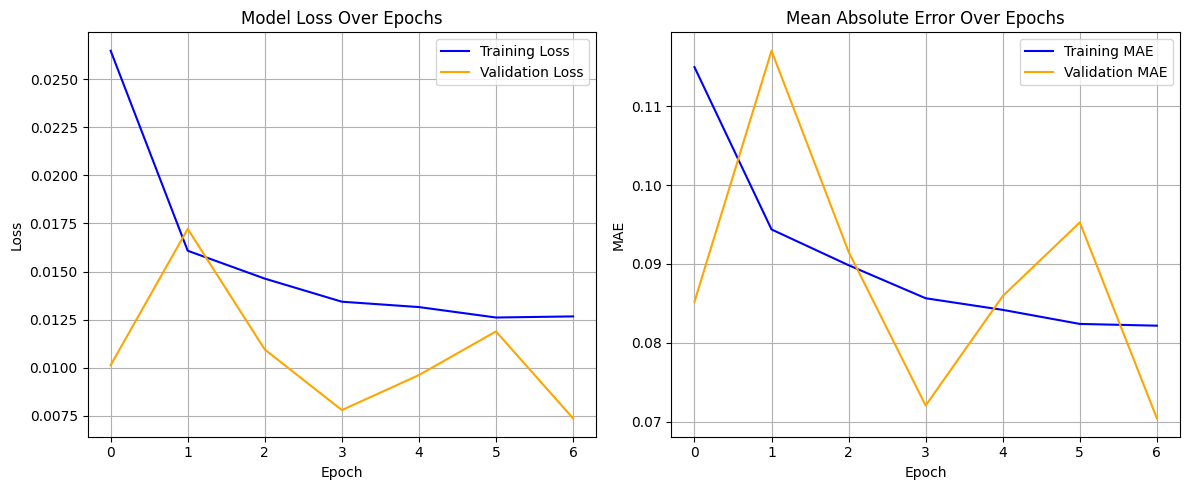

In [143]:
# Train the model and plot its accuracy
history = model.fit(X_train, y_train, batch_size=32, epochs=7, validation_data=(X_val, y_val))

# Display two subplots, the loss and mean absolute error
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(history.history['loss'], label='Training Loss', color='blue')
axs[0].plot(history.history['val_loss'], label='Validation Loss', color='orange')
axs[0].set_title('Model Loss Over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)
axs[1].plot(history.history['mae'], label='Training MAE', color='blue')
axs[1].plot(history.history['val_mae'], label='Validation MAE', color='orange')
axs[1].set_title('Mean Absolute Error Over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MAE')
axs[1].legend()
axs[1].grid(True)
plt.tight_layout()
plt.show()
